In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [2]:
FONTSIZE = 25
FIGSIZE = 10

In [3]:
# Simulation information

event_name = 'GW170817'
ifo = 'L1'

cds = 'theta1eta'
Ns = 2 * [256]
depth = 15
repeats = 10

In [4]:
snr_threshold = 8

In [5]:
cost_file = f'../cost_values/cost_values__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}.h5'

hf = h5py.File(cost_file, 'r')

qualities = -hf['cost_values'][...]
cd1 = hf['cd1'][...]
cd2 = hf['cd2'][...]
cd1_signal = hf['cd1_signal'][...]
cd2_signal = hf['cd2_signal'][...]
tc_signal = hf['tc_signal'][...]

hf.close()

In [6]:
# Results files
results_path = f'../results/{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}'

file1 = f'qmoa_complete_p{depth}_r{repeats}.h5'
file2 = f'qmoa_cycle_p{depth}_r{repeats}.h5'
file3 = f'qaoa_hypercube_p{depth}_r{repeats}.h5'
file4 = f'qaoa_complete_p{depth}_r{repeats}.h5'
file_names = [ file1, file2, file3, file4 ]

In [7]:
# Labels for algorithm in each file_names
alg1 = 'QMOA (Complete)'
alg2 = 'QMOA (Cycle)'
alg3 = 'QAOA (Hypercube)'
alg4 = 'QAOA (Complete)'
alg_names = [ alg1, alg2, alg3, alg4 ]

In [8]:
# Read in results

exp_vals = {}
prob_snr = {}
final_probs = {}

for f in range(len(file_names)):
    
    hf = h5py.File(f'{results_path}/{file_names[f]}', 'r')
    
    exp_vals[alg_names[f]] = np.empty([depth, repeats])
    prob_snr[alg_names[f]] = np.empty([depth, repeats])
    
    for p in range(1, depth+1):
        for r in range(1, repeats+1):
            state_temp = hf[f'test_{p}_{r}']['final_state'][...].view(np.complex128)
            probs_temp = abs(state_temp)**2
            exp_vals[alg_names[f]][p-1,r-1] = sum(qualities * probs_temp) / sum(probs_temp)
            prob_snr[alg_names[f]][p-1,r-1] = sum( probs_temp[qualities > snr_threshold] ) / sum(probs_temp)
            
    final_state_temp = hf[f'test_{depth}_{np.argmin(exp_vals[alg_names[f]][depth-1,:])+1}']['final_state'][...].view(np.complex128)
    final_probs[alg_names[f]] = abs(final_state_temp)**2
    
    hf.close()

In [9]:
# Restricted-depth Grover search

J = len(qualities)
J_solns = np.sum(qualities > snr_threshold)
print(f'Required depth for full Grover algorithm = {round( np.pi/(4*np.arcsin(np.sqrt(J_solns/J))) - 1/2 )}')

exp_vals['RDGS'] = np.empty([depth])
prob_snr['RDGS'] = np.empty([depth])

for p in range(1, depth+1):
    prob_grover_soln = (1/J_solns) * np.sin( (2*p+1) * np.arcsin(np.sqrt(J_solns/J)) )**2
    prob_grover_notsoln = (1/(J-J_solns)) * np.cos( (2*p+1) * np.arcsin(np.sqrt(J_solns/J)) )**2
    probs_grover = prob_grover_soln * (qualities > snr_threshold) + prob_grover_notsoln * (qualities <= snr_threshold)
    exp_vals['RDGS'][p-1] = sum( qualities * probs_grover ) / sum(probs_grover)
    prob_snr['RDGS'][p-1] = sum( probs_grover[qualities > snr_threshold] ) / sum(probs_grover)

final_probs['RDGS'] = probs_grover

Required depth for full Grover algorithm = 31


In [10]:
if cds == 'm1m2':
    cd1_label = r'$m_1 / M_\odot$'
    cd2_label = r'$m_2 / M_\odot$'
elif cds == 'theta1eta':
    cd1_label = r'$\theta_1$'
    cd2_label = r'$\eta$'
else:
    cd1_label = 'Coordinate 1'
    cd2_label = 'Coordinate 2'

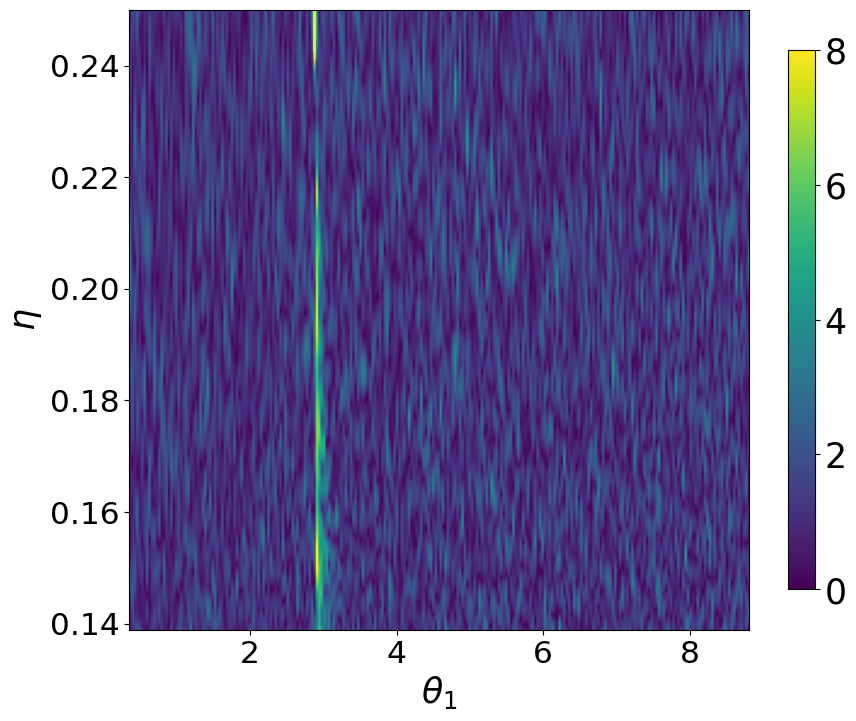

In [11]:
# Plot quality function

fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1), max(cd1), min(cd2), max(cd2))
aspect = (max(cd1)-min(cd1)) / (max(cd2)-min(cd2))
cax = ax.imshow( np.transpose(qualities.reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)
cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0,8])
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)

#ax.plot(cd1_signal, cd2_signal, 'r.', markersize=10)

fig.savefig(f'figures/SNR__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}.pdf', format='pdf', bbox_inches='tight')

In [12]:
fmt = {alg1: 's--', alg2: 'P--', alg3: '*--', alg4: '^--', 'RDGS': 'x--'}

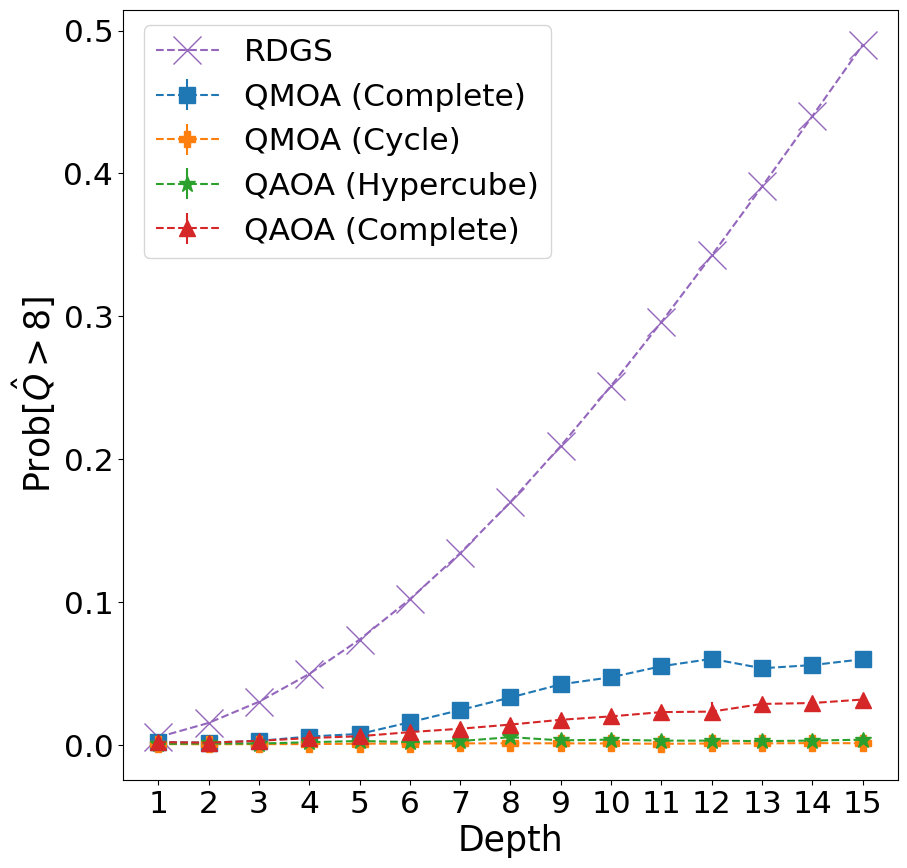

In [13]:
# Plot probability above SNR threshold

fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

#for alg in alg_names:
#    ax.errorbar( range(1, depth+1), np.sum(prob_snr[alg], axis=1)/repeats, yerr=np.array([ np.std(prob_snr[alg], axis=1), np.std(prob_snr[alg], axis=1) ]), fmt='-o', label=alg )
#ax.plot( range(1, depth+1), prob_snr['RDGS'], '-x', markersize=15, label='RDGS' )

for alg in alg_names:
    ax.errorbar( range(1, depth+1), np.sum(prob_snr[alg], axis=1)/repeats, yerr=np.array([ np.std(prob_snr[alg], axis=1), np.std(prob_snr[alg], axis=1) ]), fmt=fmt[alg], markersize=12, label=alg )
ax.plot( range(1, depth+1), prob_snr['RDGS'], fmt['RDGS'], markersize=20, label='RDGS' )

ax.set_xticks(range(1, depth+1))
ax.set_xlabel('Depth', fontsize=FONTSIZE)
ax.set_ylabel(r'Prob$[\hat{Q}$' + fr'$> {snr_threshold}]$', fontsize=FONTSIZE)
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
fig.legend(loc='upper left', bbox_to_anchor=(0.13, 0.88), fontsize=0.9*FONTSIZE)

fig.savefig(f'figures/ProbSNR__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__p{depth}__r{repeats}.pdf', format='pdf', bbox_inches='tight')

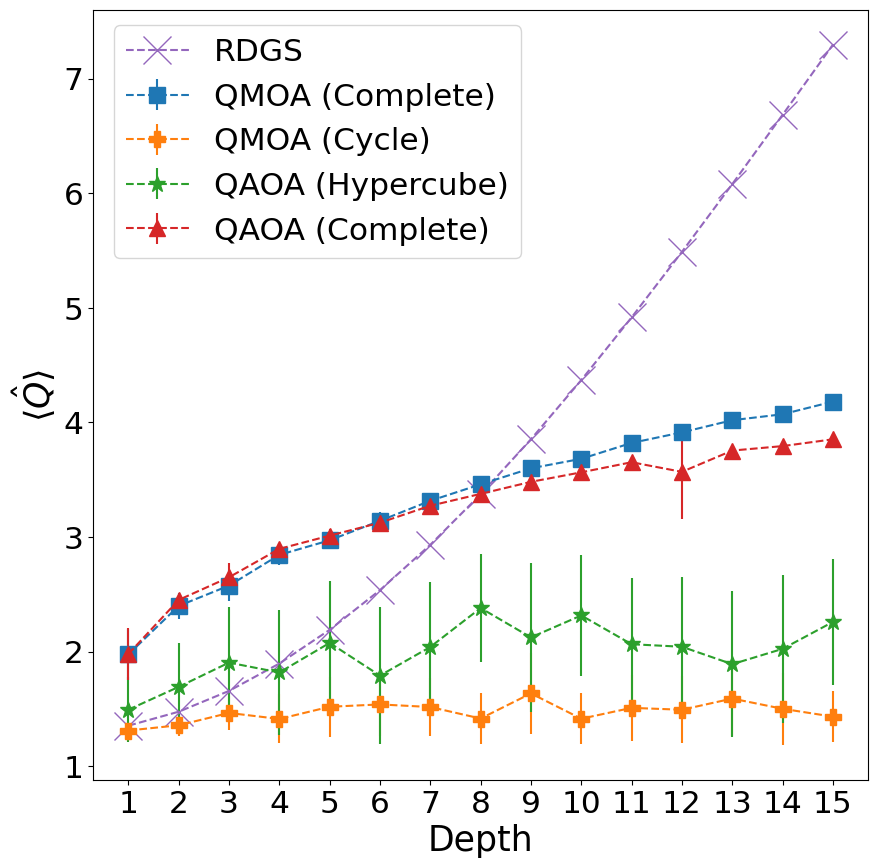

In [14]:
# Plot expectation values

fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

#for alg in alg_names:
#    ax.errorbar( range(1, depth+1), np.sum(exp_vals[alg], axis=1)/repeats, yerr=np.array([ np.std(exp_vals[alg], axis=1), np.std(exp_vals[alg], axis=1) ]), fmt='-o', label=alg )
#ax.plot( range(1, depth+1), exp_vals['RDGS'], '-x', markersize=15, label='RDGS' )

for alg in alg_names:
    ax.errorbar( range(1, depth+1), np.sum(exp_vals[alg], axis=1)/repeats, yerr=np.array([ np.std(exp_vals[alg], axis=1), np.std(exp_vals[alg], axis=1) ]), fmt=fmt[alg], markersize=12, label=alg )
ax.plot( range(1, depth+1), exp_vals['RDGS'], fmt['RDGS'], markersize=20, label='RDGS' )


ax.set_xticks(range(1, depth+1))
ax.set_xlabel('Depth', fontsize=FONTSIZE)
ax.set_ylabel(r'$\langle \hat{Q} \rangle$', fontsize=FONTSIZE)
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
fig.legend(loc='upper left', bbox_to_anchor=(0.13, 0.88), fontsize=0.9*FONTSIZE)

fig.savefig(f'figures/Expvals__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__p{depth}__r{repeats}.pdf', format='pdf', bbox_inches='tight')

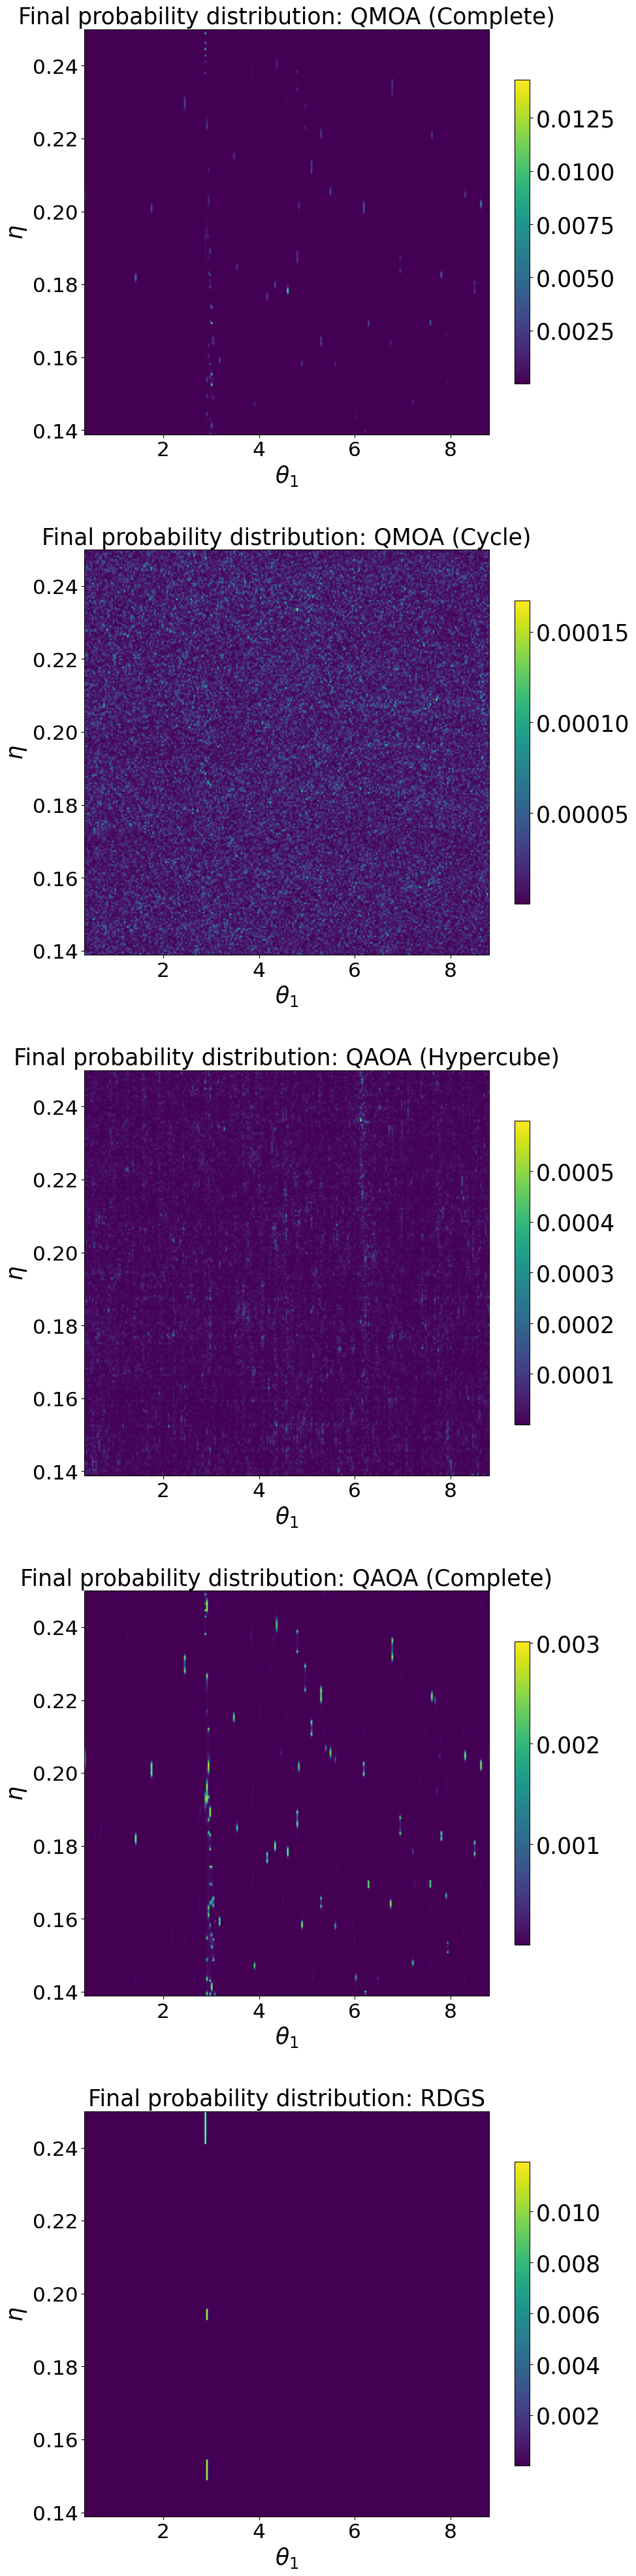

In [15]:
# Plot final probabilities

fig, ax = plt.subplots(len(alg_names)+1, 1, figsize=(FIGSIZE,(len(alg_names)+1)*FIGSIZE))
extent = (min(cd1), max(cd1), min(cd2), max(cd2))
aspect = (max(cd1)-min(cd1)) / (max(cd2)-min(cd2))

for ix in range(len(alg_names)):
    cax = ax[ix].imshow( np.transpose(final_probs[alg_names[ix]].reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )
    ax[ix].set_xlabel(cd1_label, fontsize=FONTSIZE)
    ax[ix].set_ylabel(cd2_label, fontsize=FONTSIZE)
    ax[ix].set_title(f'Final probability distribution: {alg_names[ix]}', fontsize=FONTSIZE)
    cbar = fig.colorbar(cax, ax=ax[ix], shrink=0.7)
    cbar.ax.tick_params(labelsize=FONTSIZE)
    ax[ix].tick_params(axis='both', labelsize=0.9*FONTSIZE)

cax = ax[ix+1].imshow( np.transpose(final_probs['RDGS'].reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )
ax[ix+1].set_xlabel(cd1_label, fontsize=FONTSIZE)
ax[ix+1].set_ylabel(cd2_label, fontsize=FONTSIZE)
ax[ix+1].set_title('Final probability distribution: RDGS', fontsize=FONTSIZE)
cbar = fig.colorbar(cax, ax=ax[ix+1], shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
ax[ix+1].tick_params(axis='both', labelsize=0.9*FONTSIZE)

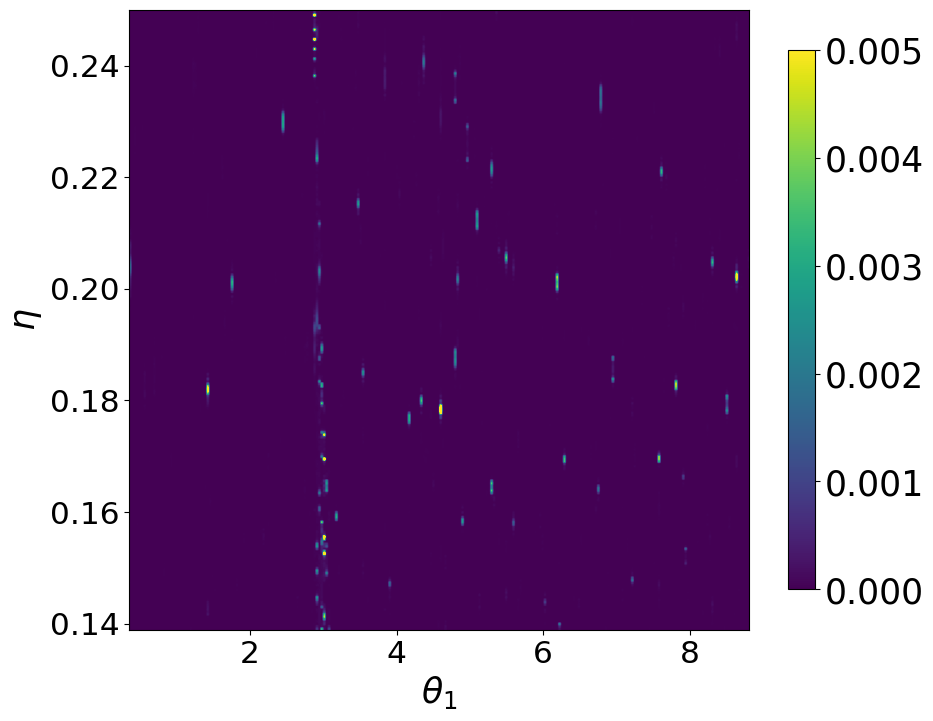

In [16]:
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1), max(cd1), min(cd2), max(cd2))
aspect = (max(cd1)-min(cd1)) / (max(cd2)-min(cd2))
cax = ax.imshow( np.transpose(final_probs[alg_names[0]].reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )

#ax.set_xticks(np.arange(1.0, 5.5, 0.5))
#ax.set_yticks(np.arange(1.0, 5.5, 0.5))
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)

cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0, 0.005])
#cax.set_clim([0, max(final_probs[alg_names[0]])])

fig.savefig(f'figures/Finalstate__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__p{depth}__r{repeats}__{alg_names[0]}.pdf', format='pdf', bbox_inches='tight')

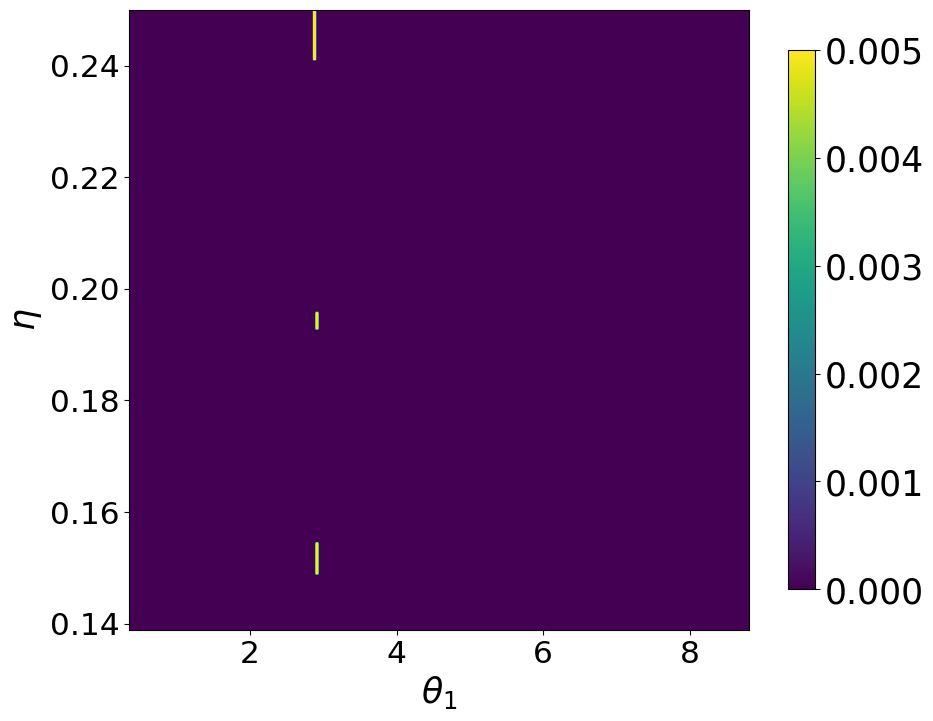

In [17]:
fig, ax = plt.subplots(figsize=(FIGSIZE,FIGSIZE))

extent = (min(cd1), max(cd1), min(cd2), max(cd2))
aspect = (max(cd1)-min(cd1)) / (max(cd2)-min(cd2))
cax = ax.imshow( np.transpose(final_probs['RDGS'].reshape(Ns)), extent=extent, aspect=aspect, origin='lower' )

#ax.set_xticks(np.arange(1.0, 5.5, 0.5))
#ax.set_yticks(np.arange(1.0, 5.5, 0.5))
ax.tick_params(axis='both', labelsize=0.9*FONTSIZE)
ax.set_xlabel(cd1_label, fontsize=FONTSIZE)
ax.set_ylabel(cd2_label, fontsize=FONTSIZE)

cbar = fig.colorbar(cax, ax=ax, shrink=0.7)
cbar.ax.tick_params(labelsize=FONTSIZE)
cax.set_clim([0, 0.005])
#cax.set_clim([0, max(final_probs['RDGS'])])

fig.savefig(f'figures/Finalstate__{event_name}__{ifo}__{cds}__Ns_{Ns[0]}_{Ns[1]}__p{depth}__r{repeats}__RDGS.pdf', format='pdf', bbox_inches='tight')